In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.special import gammaln, digamma
import itertools
from tqdm import tqdm
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [90]:
n_timestep = 6
n_velocity = 40
n_action = 2
n_position = 50
min_position, max_position = 0, 70.0
min_velocity, max_velocity = -5.0, 5.0

timestep = np.linspace(
    0,
    1.0,
    n_timestep)
velocity = np.linspace(
    min_velocity,
    max_velocity,
    n_velocity)
action = np.arange(
    n_action)
position = np.linspace(
    min_position,
    max_position,
    n_position)

# max_velocity = 10.0
friction_factor = 0.5

n_sample_run = 20

def square_exponential_kernel(x, alpha, length):
    return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)


def sample_action_effect(t, size=1):
    mu = 0.4 + 1.2 * np.cos(3 * (t - 2))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)


def sample_own_force(t, size=1):

    mu = 0.5 + 0.5*np.cos(6*(t + 5))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

n_sample = 300
# Building the velocity transaction matrix
own_force = sample_own_force(timestep, size=n_sample)
action_effect = sample_action_effect(timestep, size=n_sample)

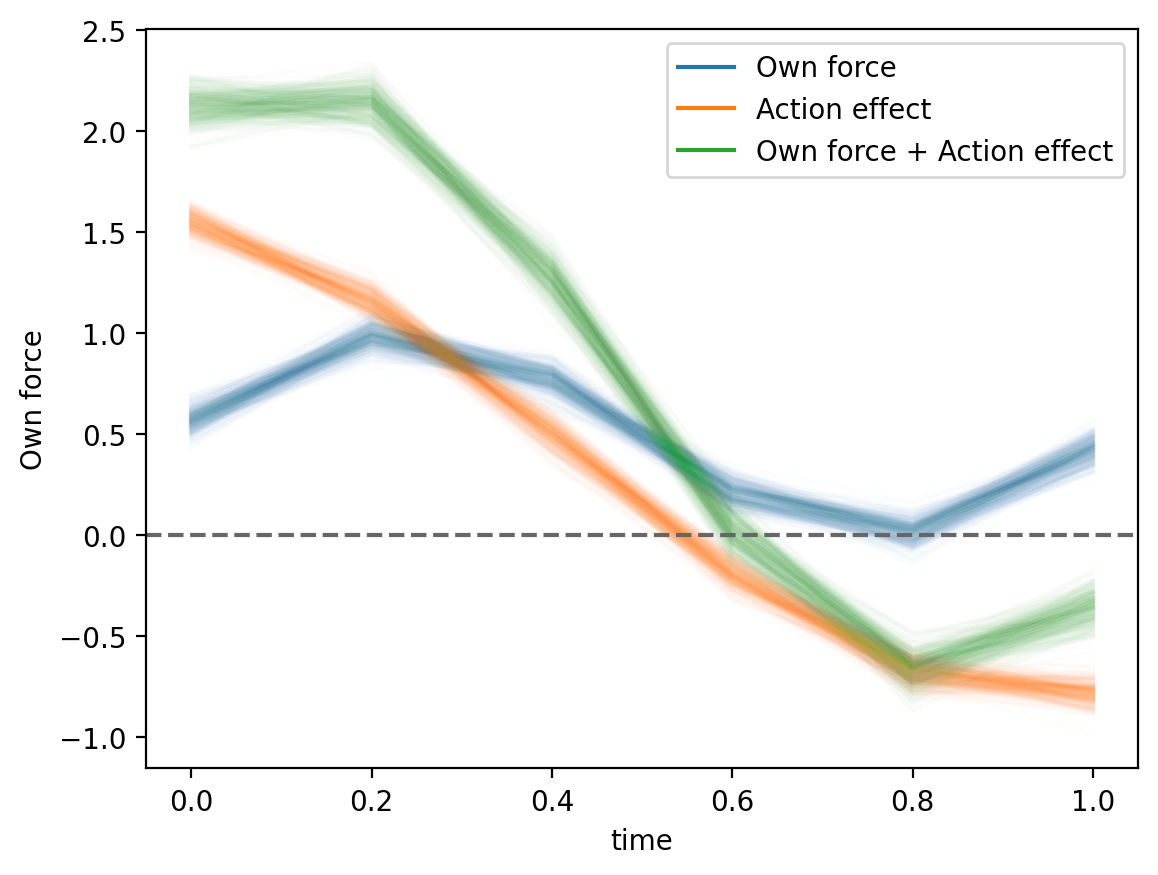

In [91]:
fig, ax = plt.subplots()
for y_ in own_force:
    ax.plot(timestep, y_, color="C0", alpha=0.01)
ax.plot([], [], color="C0", label="Own force")

for y_ in action_effect:
    ax.plot(timestep, y_, color="C1", alpha=0.01)
ax.plot([], [], color="C1", label="Action effect")

for y_ in own_force + action_effect:
    ax.plot(timestep, y_, color="C2", alpha=0.01)
ax.plot([], [], color="C2", label="Own force + Action effect")


ax.set_xlabel("time")
ax.set_ylabel("Own force")
#ax.set_ylim(None, 1)
ax.axhline(y=0.0, ls="--", color="0.4")
ax.legend();

In [92]:
# Compute the 'true' transition probabilities for the velocity
transition_velocity_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity))
for v_idx, v in enumerate(velocity):
    for t_idx, t in enumerate(timestep):
        for a in action:
            new_v = np.zeros(n_sample)
            new_v += v - friction_factor*v
            new_v += action_effect[:, t_idx]*a
            new_v += own_force[:, t_idx]
            new_v = np.clip(new_v, min_velocity, max_velocity)
            hist, bins = np.histogram(
                new_v,
                bins=list(velocity) + [velocity[-1] + (velocity[-1] - velocity[-2])])
            sum_hist = np.sum(hist)
            assert sum_hist > 0, "Sum of transition probabilities is 0"
            density = hist / sum_hist
            transition_velocity_tavv[t_idx, a, v_idx, :] = density

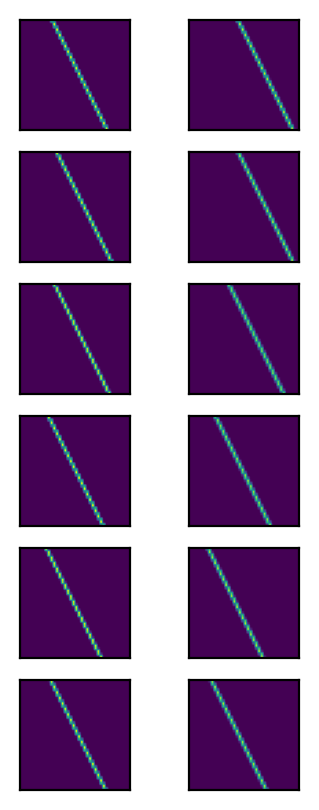

In [93]:
fig, axes = plt.subplots(ncols=n_action, nrows=n_timestep, figsize=(2, 5))
for a in range(n_action):
    for t in range(n_timestep):
        ax = axes[t, a]
        img = transition_velocity_tavv[t, a, :, :]
        ax.imshow(img, aspect=1, vmin=0, vmax=1.0)
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

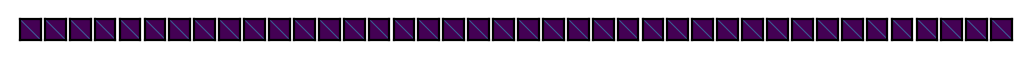

In [94]:
transition_position_pvp = np.zeros((n_position, n_velocity, n_position))
for p_idx, p in enumerate(
        position):
    for v_idx, v in enumerate(
            velocity):
        transition_position_pvp[p_idx, v_idx, :] = norm.pdf(
                position,
                loc=p + (1 / n_timestep) * v,
                scale=0.5)
        sum_transition = transition_position_pvp[p_idx, v_idx, :].sum()
        assert sum_transition > 0, "Sum of transition probabilities is 0"
        transition_position_pvp[p_idx, v_idx, :] /= sum_transition

fig, axes = plt.subplots(ncols=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position_pvp[:, i, :]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])